# Importing libraries

In [354]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import evds as ev
import pandas as pd 
import numpy as np
import seaborn as sns
from arch.unitroot import ADF,PhillipsPerron,KPSS,ZivotAndrews
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import month_plot
import statsmodels.api as sm
from merlion.models.utils.autosarima_utils import nsdiffs
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import inv_boxcox
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox,het_arch

# Dataset

## About the dataset

* **Consumer Price Index (CPI)  is a measure of the general price level in the  economy.**
* The dataset named "TP.FG.J0" used in the application has been retrieved using the API service from the website https://evds2.tcmb.gov.tr/, starting from "01-01-2003" until "31-12-2023".     
Below is how it was obtained.


In [388]:
with open("Evds.txt") as file: # The "Evds.txt" file contains my personal API key. The dataset has been loaded along with other files.
    api = file.read()

In [383]:
evds= ev.evdsAPI(api)
CPI= evds.get_data(["TP.FG.J0"], startdate="01-01-2003", enddate="31-12-2023",frequency=5)
CPI.rename(columns={"TP_FG_J0":"CPI"},inplace=True)
tarih=pd.date_range("01-01-2003",periods=len(CPI),freq="M")
CPI["Tarih"]=tarih
CPI.set_index("Tarih",inplace=True)
CPI

,CPI
Tarih,
2003-01-31,94.77
2003-02-28,96.23
2003-03-31,98.12
2003-04-30,99.09
2003-05-31,100.04
...,...
2023-08-31,1614.31
2023-09-30,1691.04
2023-10-31,1749.11


## Base year conversion

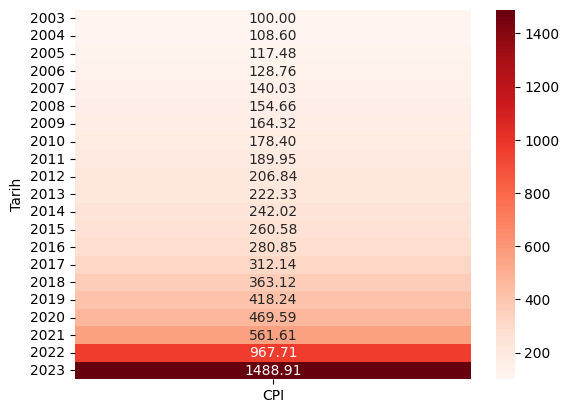

In [357]:
df= CPI.resample("Y").mean()
df.index= df.index.year
sns.heatmap(df,annot=True,fmt=".2f",cmap="Reds")
plt.show()

In [358]:
inflation_monthly=CPI["CPI"].pct_change()*100 # Monthly
inflation_monthly.dropna(inplace=True)
inflation_monthly=pd.DataFrame(inflation_monthly)
inflation_monthly.rename(columns={"CPI":"Inflation"},inplace=True)
inflation_yearly=CPI["CPI"].pct_change(12)*100 # Yearly
inflation_yearly.dropna(inplace=True)
inflation_yearly=pd.DataFrame(inflation_yearly)
inflation_yearly.rename(columns={"CPI":"Inflation"},inplace=True)

In [359]:
print(inflation_yearly)

            Inflation
Tarih                
2004-01-31  10.594070
2004-02-29   9.477294
2004-03-31   8.397880
2004-04-30   7.871632
2004-05-31   7.307077
...               ...
2023-08-31  58.943534
2023-09-30  61.529865
2023-10-31  61.357011
2023-11-30  61.980166
2023-12-31  64.772919

[240 rows x 1 columns]


# Application and Analysis of Econometric Tests

## Unit root test

Unit root tests are statistical tests used to determine the stationarity property of a time series. If a time series possesses the stationarity property, its statistical characteristics remain constant over time. Therefore, unit root tests are important for the statistical analysis of time series data.     
 Among the commonly used unit root tests are the Augmented Dickey-Fuller (ADF) test, the Phillips-Perron (PP) test, and the KPSS test.

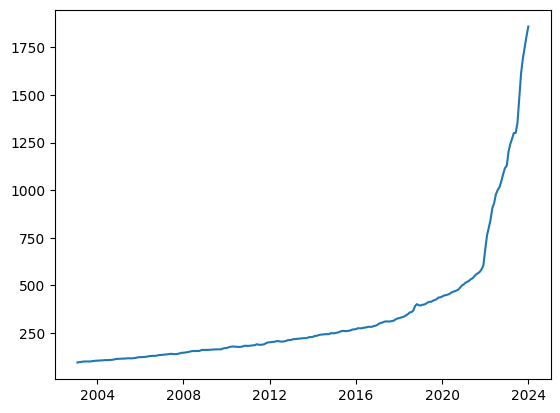

In [360]:
plt.plot(CPI)
plt.show()


* In the graphical examination, it is considered that there is a non-stationary structure and a structural break.


In [361]:
adf = ADF(CPI,trend="ct")
pp= PhillipsPerron(CPI,trend="ct")
kpss=KPSS(CPI,trend="ct")

In [362]:
print(adf)
print(pp)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                  6.101
P-value                         1.000
Lags                               16
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.00 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 17.424
P-value                         1.000
Lags                               16
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.00 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.370
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant and Linear 

### The interpretation of the test results

ADF Test and Phillips perron Test     
* Null Hypothesis: **The process contains a unit root**


KPSS Stationarity Test
* Null Hypothesis: **The process is weakly stationary.**


|               | Test Statistic       | PP-value    | Decision      |
|--             | --------             | --------    |--------   
|ADF            |  6.101               | 1.000       |Null hypothesis is rejected.
|PP             | 17.424               | 1.000       |Null hypothesis cannot be rejected.
|KPSS           | 0.370                |0.000        |Null hypothesis cannot be rejected.

In [363]:
adf.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     55.99
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           6.04e-71
Time:                        13:41:34   Log-Likelihood:                -812.23
No. Observations:                 235   AIC:                             1662.
Df Residuals:                     216   BIC:                             1728.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1       0.0902      0.015      6.101      0.000       0.061       0.119
Diff.L1        0.6240      0.073      8.510      0.000       0.479       0.768
Diff.L2       -0.3929      0.085     -4.639      0.000      -0.560      -0.226
Diff.L3       -0.0955      0.088     -1.090      0.277      -0.268       0.077
Diff.L4       -0.3106      0.088     -3.536      0.000      -0.484      -0.137
Diff.L5        0.1558      0.090      1.738      0.084      -0.021       0.333
Diff.L6       -0.0169      0.093     -0.183      0.855      -0.200       0.166
Diff.L7        0.0211      0.092      0.229      0.819      -0.160       0.203
Diff.L8       -0.4955      0.094     -5.290      0.000      -0.680      -0.311
Diff.L9        0.3377      0.096      3.526      0.001       0.149       0.527
Diff.L10      -0.2098      0.098     -2.138      0.034      -0.403      -0.016
Diff.L11      -0.4473      0.102     -4.392      0.000      -0.648      -0.247
Diff.L12       0.0733      0.119      0.616      0.538      -0.161       0.308
Diff.L13       0.2059      0.126      1.636      0.103      -0.042       0.454
Diff.L14      -0.3224      0.127     -2.538      0.012      -0.573      -0.072
Diff.L15       0.1609      0.130      1.235      0.218      -0.096       0.418
Diff.L16      -0.3542      0.114     -3.102      0.002      -0.579      -0.129
const         -6.5349      1.435     -4.554      0.000      -9.363      -3.707
trend         -0.1059      0.022     -4.899      0.000      -0.148      -0.063
==============================================================================
Omnibus:                      174.466   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3606.170
Skew:                           2.598   Prob(JB):                         0.00
Kurtosis:                      21.474   Cond. No.                     1.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* **The series is not stationary in levels.**

## Zivot-Andrews Structural Beak Test


The Zivot-Andrews structural break test alleges the presence of a sudden change or breakpoint at a certain point in a time series and provides an analysis to identify this breakpoint.

In [364]:
trend= ["c","ct","t"]
for i in trend:
    z=ZivotAndrews(CPI,trend=i)
    print(z)

        Zivot-Andrews Results        
Test Statistic                  5.583
P-value                         0.999
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.
        Zivot-Andrews Results        
Test Statistic                  3.724
P-value                         0.999
Lags                               16
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.
        Zivot-Andrews Results        
Test Statistic                  3.922
P-value                         0.999
Lags                               16
--------

Zivot-Andrews Test     
* Null Hypothesis: **The process contains a unit root with a single structural break.**




|    Trend           | Test Statistic       | PP-value    | Decision      |
|--                  | --------             | --------    |--------   
|Constant                 |  5.583               |  0.999       |Null hypothesis cannot be rejected.
|Constant and Linear Time | 3.724                |  0.999       |Null hypothesis cannot be rejected.
|Linear Time              |  3.922               | 0.999        |Null hypothesis cannot be rejected.

* If the ADF, PP, and KPSS tests confirm stationarity in the structural break test, and the Zivot test also confirms stationarity, then we can say there is a structural break.      
**But, according to this test result, there is no structural break.**


## The division of data into testing and training sets

In [389]:
CPI_train = CPI.iloc[:-36]
CPI_test = CPI.iloc[-36:]
print(CPI_train)
print(CPI_test)

               CPI
Tarih             
2003-01-31   94.77
2003-02-28   96.23
2003-03-31   98.12
2003-04-30   99.09
2003-05-31  100.04
...            ...
2020-08-31  472.61
2020-09-30  477.21
2020-10-31  487.38
2020-11-30  498.58
2020-12-31  504.81

[216 rows x 1 columns]
                CPI
Tarih              
2021-01-31   513.30
2021-02-28   517.96
2021-03-31   523.53
2021-04-30   532.32
2021-05-31   537.05
2021-06-30   547.48
2021-07-31   557.36
2021-08-31   563.60
2021-09-30   570.66
2021-10-31   584.32
2021-11-30   604.84
2021-12-31   686.95
2022-01-31   763.23
2022-02-28   799.93
2022-03-31   843.64
2022-04-30   904.79
2022-05-31   931.76
2022-06-30   977.90
2022-07-31  1001.03
2022-08-31  1015.65
2022-09-30  1046.89
2022-10-31  1084.00
2022-11-30  1115.26
2022-12-31  1128.45
2023-01-31  1203.48
2023-02-28  1241.33
2023-03-31  1269.75
2023-04-30  1300.04
2023-05-31  1300.60
2023-06-30  1351.59
2023-07-31  1479.84
2023-08-31  1614.31
2023-09-30  1691.04
2023-10-31  1749.11
2023-11-3

###  The Box-Cox transformation 

The Box-Cox transformation is a data transformation method used to stabilize variance or approximate a normal distribution. It is a parametric transformation method that allows for more flexibility compared to non-parametric methods.

The Box-Cox transformation is expressed by the following formula:    

$ y^{(\lambda)} = \begin{cases} \frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0, \\ \log(y), & \text{if } \lambda = 0. \end{cases} $


Here, `y` represents the variable to be transformed, and `λ` is the transformation parameter. Different values of `λ` correspond to different transformations:

- `λ = 1`: Linear transformation
- `λ = 0`: Logarithmic transformation
- `λ > 0`: Power transformation (one of the important values)

The Box-Cox transformation is commonly used, especially in regression analysis or time series data, to approximate variables to a normal distribution or to stabilize variance among variables. However, before applying it, it's essential to try different transformation parameter values and evaluate the results to determine which transformation parameter is most suitable. This is particularly important to consider in the statistical modeling process.


In [366]:
CPI_train_bx,lm=boxcox(CPI_train["CPI"])
CPI_train["Box-Cox"]=CPI_train_bx
print(CPI_train)

               CPI   Box-Cox
Tarih                       
2003-01-31   94.77  2.722772
2003-02-28   96.23  2.727684
2003-03-31   98.12  2.733906
2003-04-30   99.09  2.737042
2003-05-31  100.04  2.740075
...            ...       ...
2020-08-31  472.61  3.149028
2020-09-30  477.21  3.151115
2020-10-31  487.38  3.155642
2020-11-30  498.58  3.160492
2020-12-31  504.81  3.163131

[216 rows x 2 columns]


## Seasonal effect

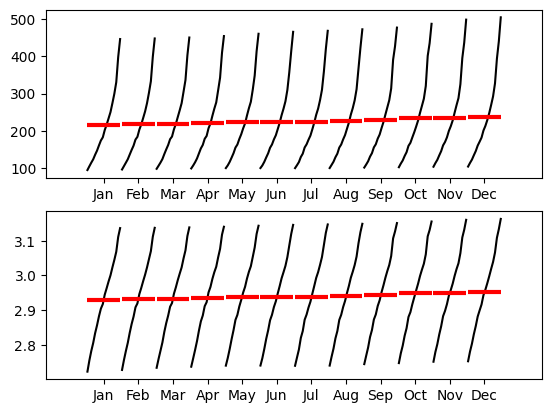

In [367]:
fig, ax = plt.subplots(2,1)
month_plot(CPI_train["CPI"],ax=ax[0])
month_plot(CPI_train["Box-Cox"],ax=ax[1])
plt.show()


* This test measures whether there is a seasonal effect. Significant deviations in the red lines suggest the presence of seasonality. However, such evidence is not found in our CPI series.   
Yet, this test can be misleading in index data. In countries like Turkey where there is no deflation, CPI always moves upwards, so different tests should be used to investigate seasonality


### The addition of dummy variables to the model

In [368]:
for_dummy_model_train= CPI_train.copy()
for_dummy_model_test= CPI_test.copy()


In [369]:
for_dummy_model_train["Month"]=CPI_train.index.month
dummy= pd.get_dummies(for_dummy_model_train["Month"],prefix="Month",dtype=int,drop_first=False)
for_dummy_model_train =pd.concat([for_dummy_model_train,dummy],axis=1)
print(for_dummy_model_train)

               CPI   Box-Cox  Month  Month_1  Month_2  Month_3  Month_4  \
Tarih                                                                     
2003-01-31   94.77  2.722772      1        1        0        0        0   
2003-02-28   96.23  2.727684      2        0        1        0        0   
2003-03-31   98.12  2.733906      3        0        0        1        0   
2003-04-30   99.09  2.737042      4        0        0        0        1   
2003-05-31  100.04  2.740075      5        0        0        0        0   
...            ...       ...    ...      ...      ...      ...      ...   
2020-08-31  472.61  3.149028      8        0        0        0        0   
2020-09-30  477.21  3.151115      9        0        0        0        0   
2020-10-31  487.38  3.155642     10        0        0        0        0   
2020-11-30  498.58  3.160492     11        0        0        0        0   
2020-12-31  504.81  3.163131     12        0        0        0        0   

            Month_5  Mon

In [371]:
x= for_dummy_model_train.drop(columns=["CPI","Box-Cox","Month"])
y=for_dummy_model_train['CPI']
dummy_model = sm.OLS(y,x).fit()
print(dummy_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                   0.07157
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               1.00
Time:                        13:45:04   Log-Likelihood:                -1311.9
No. Observations:                 216   AIC:                             2648.
Df Residuals:                     204   BIC:                             2688.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month_1      216.1194     25.489      8.479      0.0

* According to the F-statistic, the model is not significant. There is no deterministic seasonality


In [ ]:
for_nsdiffs_train=CPI_train.copy()

In [ ]:
a= nsdiffs(for_nsdiffs_train["Box-Cox"],m=12,test="ch")
b= nsdiffs(for_nsdiffs_train["Box-Cox"],m=12,test="ocsb")
print(a)
print(b)

0
0



* The "nsdiffs" function calculates how many differences need to be taken for a time series to become stationary. The "ch" parameter refers to the Canova-Hansen test. The "ocsb" parameter refers to the Osborn-Chui-Smith-Birchenhall test. Both A and B values being zero indicate that neither test suggests the presence of seasonality.

## Building the Model with Regression

In [ ]:
for_linear_reg_train=CPI_train.copy()


In [ ]:
indeks= np.arange(1,len(for_linear_reg_train)+1)
for_linear_reg_train["T"]=indeks
x=sm.add_constant(for_linear_reg_train["T"])
y=for_linear_reg_train["Box-Cox"]
linear_model=sm.OLS(y,x).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Box-Cox   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.494e+04
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          1.08e-250
Time:                        00:10:19   Log-Likelihood:                 731.18
No. Observations:                 216   AIC:                            -1458.
Df Residuals:                     214   BIC:                            -1452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7333      0.001   2430.652      0.0

* According to the F-statistic, the model is significant. The coefficients are statistically significant. An R-squared value of 0.995 raises the possibility of spurious regression.    
In non-stationary series, spurious regression is often encountered. The very low value of the Durbin-Watson statistic further supports the possibility of spurious regression.


In [ ]:
for_pol_reg_train= CPI_train.copy()
for_pol_reg_test=CPI_test.copy()


In [ ]:
indeks= np.arange(1,len(for_pol_reg_train)+1)
for_pol_reg_train["T"]=indeks
pol= PolynomialFeatures(degree=3)
xp=pol.fit_transform(for_pol_reg_train["T"].values.reshape(-1,1))
y=for_pol_reg_train["Box-Cox"]
pol_model=sm.OLS(y,xp).fit()
print(pol_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Box-Cox   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.976e+04
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          1.42e-301
Time:                        00:10:25   Log-Likelihood:                 861.47
No. Observations:                 216   AIC:                            -1715.
Df Residuals:                     212   BIC:                            -1701.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7180      0.001   2168.197      0.0

* When a third-degree polynomial regression is used to recreate the model to test for the presence of spurious regression, despite the increase in the R-squared value and the relatively higher Durbin-Watson statistic, it was deemed insufficient. We can conclude that there is spurious regression.


### Spurious Regression Test with test data

In [372]:

girdi= np.arange(len(for_pol_reg_train.index)+1,len(for_pol_reg_train.index)+37)
tahmin=pol_model.predict(pol.fit_transform(girdi.reshape(-1,1)))
tahmin=inv_boxcox(tahmin,lm)
for_pol_reg_test["Tahmin"]= tahmin
print(for_pol_reg_test)

                CPI      Tahmin
Tarih                          
2021-01-31   513.30  516.598012
2021-02-28   517.96  524.009584
2021-03-31   523.53  531.615321
2021-04-30   532.32  539.421985
2021-05-31   537.05  547.436627
2021-06-30   547.48  555.666598
2021-07-31   557.36  564.119566
2021-08-31   563.60  572.803535
2021-09-30   570.66  581.726856
2021-10-31   584.32  590.898253
2021-11-30   604.84  600.326834
2021-12-31   686.95  610.022120
2022-01-31   763.23  619.994060
2022-02-28   799.93  630.253057
2022-03-31   843.64  640.809993
2022-04-30   904.79  651.676256
2022-05-31   931.76  662.863763
2022-06-30   977.90  674.384996
2022-07-31  1001.03  686.253029
2022-08-31  1015.65  698.481561
2022-09-30  1046.89  711.084956
2022-10-31  1084.00  724.078276
2022-11-30  1115.26  737.477326
2022-12-31  1128.45  751.298693
2023-01-31  1203.48  765.559795
2023-02-28  1241.33  780.278928
2023-03-31  1269.75  795.475321
2023-04-30  1300.04  811.169190
2023-05-31  1300.60  827.381799
2023-06-

* Despite achieving a 99% success rate according to the R-squared in the regression model, when compared with the test data, almost a twofold deviation is observed.


## Holt Model

* The Holt model is a forecasting model that takes into account trend and irregular components in time series data. It is used to predict time series data using simple exponential smoothing. The Holt model attempts to forecast future values by considering both the trend and irregular components of the series, making it particularly suitable for time series with a regular increasing or decreasing trend.


In [ ]:
for_hot_model_train=CPI_train.copy()
for_hot_model_test=CPI_test.copy()


In [380]:
hot_model= Holt(for_hot_model_train["Box-Cox"]).fit(optimized=True)
tahmin=hot_model.forecast(36)
tahmin=inv_boxcox(tahmin,lm)
r_square=r2_score(for_hot_model_test["CPI"],tahmin)
RMSE= np.sqrt(mean_squared_error(for_hot_model_test["CPI"],tahmin))
print(f"R-square: {r_square}")
print(f"RMSE: {RMSE}")

R-square: -0.4364909772497676
RMSE: 489.9585928644117


## Holt-Winters Model

* The Holt model considers the trend component in time series, while the Holt-Winters model takes into account both the trend and seasonal components. The Holt-Winters model is used to forecast both regular trends and seasonal patterns in time series data. Therefore, the Holt-Winters model is a more comprehensive forecasting model and is more suitable for time series data with seasonal effects.


In [381]:
for_holt_winters_model_train= CPI_train.copy()
for_holt_winters_model_test= CPI_test.copy()

In [ ]:
trend_tip=["add","mul"]
seas_tip=["add","mul"]
per=range(2,13)

In [ ]:
sonuc=pd.DataFrame(columns=["Trend","Mevsimsellik","Periyod","RMSE"])
for i in trend_tip:
    for j in seas_tip:
        for k in per:
            holt_winters_model=ExponentialSmoothing(for_holt_winters_model_train["Box-Cox"],trend=i,seasonal=j,seasonal_periods=k).fit(optimized=True)
            holt_winters_tahmin=holt_winters_model.forecast(36)
            holt_winters_tahmin=inv_boxcox(holt_winters_tahmin,lm)
            rmse=np.sqrt(mean_squared_error(for_holt_winters_model_test["CPI"],holt_winters_tahmin))
            sonuc=sonuc._append({"Trend":i,"Mevsimsellik":j,"Periyod":k,"RMSE":rmse},ignore_index=True)
sonuc=sonuc.sort_values(by="RMSE")
print(sonuc)


   Trend Mevsimsellik Periyod        RMSE
26   mul          add       6  493.582662
37   mul          mul       6  493.832807
39   mul          mul       8  510.060781
42   mul          mul      11  510.331166
28   mul          add       8  510.430950
31   mul          add      11  511.332321
38   mul          mul       7  511.722849
35   mul          mul       4  511.828961
24   mul          add       4  511.830611
27   mul          add       7  511.890842
34   mul          mul       3  511.969290
23   mul          add       3  512.011767
25   mul          add       5  512.070230
22   mul          add       2  513.024278
30   mul          add      10  513.048927
33   mul          mul       2  513.219522
41   mul          mul      10  513.220596
40   mul          mul       9  513.377035
29   mul          add       9  513.492419
43   mul          mul      12  513.891430
32   mul          add      12  513.923116
36   mul          mul       5  514.926024
17   add          mul       8  518

* The RMSE value of the Holt model is 489.96, while the RMSE value of the Holt-Winters model is 493.58. The difference in RMSE values between the two models is quite small. This may indicate that the Holt-Winters model, with its multiplicative trend component, better captures the seasonal patterns in the dataset and makes better predictions. However, due to the small difference, it can be difficult to determine conclusively which model performs better.



## ARIMA Model

In [ ]:
for_arima_model_train = CPI_train.copy()
for_arima_model_test = CPI_test.copy()

In [ ]:
arima_model=auto_arima(for_arima_model_train["Box-Cox"],seasonal=False,trace=False)
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(0, 1, 2)   Log Likelihood                1025.511
Date:                Sat, 13 Apr 2024   AIC                          -2043.022
Time:                        22:37:39   BIC                          -2029.539
Sample:                    01-31-2003   HQIC                         -2037.574
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.000     10.597      0.000       0.002       0.002
ma.L1          0.3465      0.066      5.236      0.000       0.217       0.476
ma.L2         -0.0945      0.072     -1.320      0.1

In [ ]:
sonuc=pd.DataFrame(columns=["m","AIC"])
for i in range(2,13):
    arima_model_seasonal=auto_arima(for_arima_model_train["Box-Cox"],seasonal=True,trace=False,m=i)
    sonuc=sonuc._append({"m":i,"AIC":arima_model_seasonal.aic()},ignore_index=True)


In [ ]:
sonuc=sonuc.sort_values(by="AIC")
print(sonuc)

       m          AIC
10  12.0 -2090.776081
4    6.0 -2078.929540
2    4.0 -2045.939823
0    2.0 -2045.238526
6    8.0 -2043.414995
8   10.0 -2043.317069
3    5.0 -2043.315089
1    3.0 -2043.188448
5    7.0 -2043.021560
7    9.0 -2043.021560
9   11.0 -2043.021560


* When the AIC values are sorted, it is determined that the most suitable period is 12.


In [ ]:
arima_model=auto_arima(for_arima_model_train["Box-Cox"],seasonal=True,trace=False,m=12)
print(arima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  216
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 12)   Log Likelihood                1052.388
Date:                              Sat, 13 Apr 2024   AIC                          -2090.776
Time:                                      22:46:54   BIC                          -2067.182
Sample:                                  01-31-2003   HQIC                         -2081.243
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.325      0.185   -8.28e-05       0.000
ma.L1          0.32

* The parameters ma.L2 and intercept are removed from the model due to being statistically insignificant.


In [382]:
model=SARIMAX(for_arima_model_train["Box-Cox"],order=(0,1,1),seasonal_order=(2,0,1,12),trend="n").fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Box-Cox   No. Observations:                  216
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                1038.292
Date:                            Sun, 14 Apr 2024   AIC                          -2066.584
Time:                                    18:34:03   BIC                          -2049.731
Sample:                                01-31-2003   HQIC                         -2059.775
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5555      0.036     15.440      0.000       0.485       0.626
ar.S.L12       0.7619      0.131   

* The parameter ar.S.L24 is removed from the model due to being statistically insignificant. 
* The parameter "ar.S.L24" represents the seasonal autoregressive structure in the time series data. In the expression "ar.S.L24", "L24" denotes a lag of 24 periods.


In [ ]:
model=SARIMAX(for_arima_model_train["Box-Cox"],order=(0,1,1),seasonal_order=(1,0,1,12),trend="n").fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Box-Cox   No. Observations:                  216
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                1034.709
Date:                            Sat, 13 Apr 2024   AIC                          -2061.417
Time:                                    23:00:39   BIC                          -2047.935
Sample:                                01-31-2003   HQIC                         -2055.970
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5555      0.039     14.282      0.000       0.479       0.632
ar.S.L12       0.9274      0.056   

* The model with the lowest AIC value and all parameters statistically significant has been reached. This is the final model.

## Ljung-Box test and ARCH effect

In [ ]:
q=acorr_ljungbox(model.resid)
h=het_arch(model.resid,nlags=1,ddof=3)[1]
print(q)
print(h)

     lb_stat  lb_pvalue
1   0.000538   0.981496
2   0.000910   0.999545
3   0.000914   0.999993
4   0.001005   1.000000
5   0.001116   1.000000
6   0.001136   1.000000
7   0.001141   1.000000
8   0.001420   1.000000
9   0.001423   1.000000
10  0.001619   1.000000
0.016073698362531117


* Ljung-Box test is used to determine the autocorrelation of the error terms in the model.
* het_arch value represents the p-value of the ARCH (Autoregressive Conditional Heteroscedasticity) test or the statistical significance of the ARCH effect.

Looking at the results:
* Ljung-Box test:
    * When examining the results of the Ljung-Box test, the p-values for all time intervals are quite high at the 0.05 significance level. This indicates that there is no autocorrelation in the error terms, or in other words, the errors of the model are independent.
* ARCH effect:
    * The p-value given as the result of the ARCH test (0.016073698362531117) is quite low. This suggests that there is an ARCH effect, indicating that the model's errors may have ARCH properties. However, since a significance level of 0.05 was not used for the ARCH test, making a definitive interpretation can be difficult.

* __As a result, we can interpret that the error terms of the model are independent and there is no autocorrelation, but there may be an ARCH effect.__